В данном домашнем задании необходимо обучить сеть GAN для генерации изображений лиц

In [1]:
import keras 
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Input, Flatten
from tensorflow.keras.layers import LeakyReLU, Dense, Add, GlobalAveragePooling2D, ReLU, Conv2DTranspose
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

RANDOM_STATE = 42

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

Для этого проекта я использую файлы изображений портретов в формате .jpg. Набор данных включает в себя различных исполнителей. Я загружаю данные в виде TensorFlow.Набор данных,, с размером пакета 64. Я уменьшил размер изображения до (64,64), предполагая, что это будет менее обременительно с точки зрения вычислений для графического процессора.

In [3]:
data_path = "C:/Users/User/images/"
batch_s = 100

data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 63565 files belonging to 1 classes.


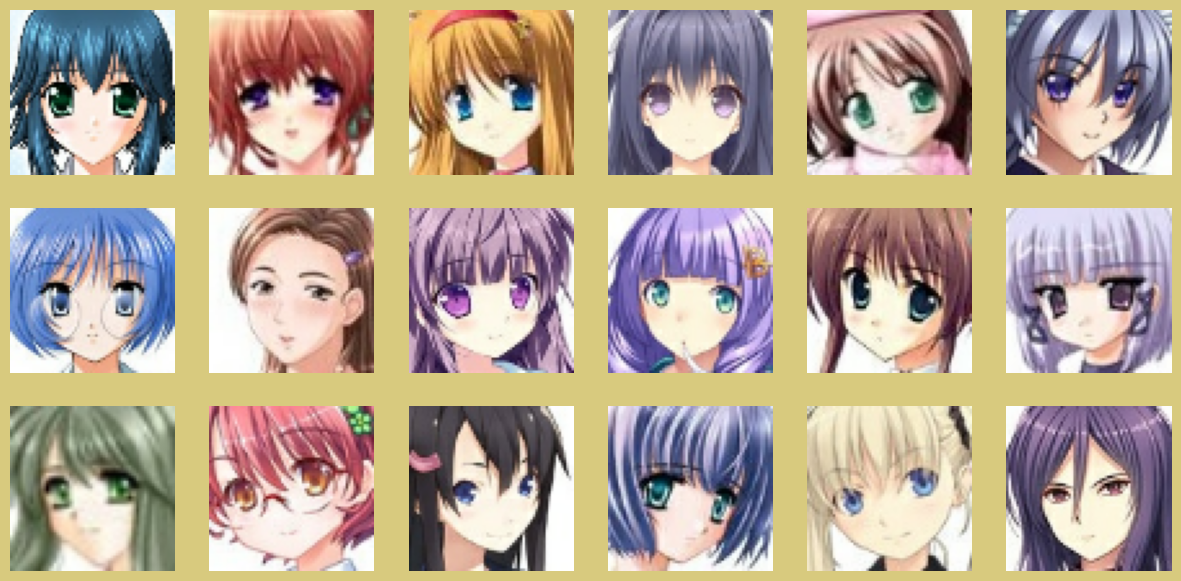

In [4]:
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
           
Show_Img(data)

* Нормализация:** Для нормализации данных я преобразую данные в диапазоне от 0 до 1. Это способствует быстрой конвергенции и позволяет компьютеру выполнять вычисления быстрее. Каждый из трех каналов RGB на изображении может принимать значения пикселей в диапазоне от 0 до 256. Деление его на 255 преобразует его в диапазон от 0 до 1. Делая это, мы

In [5]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [6]:
# Weights initializer
init = tf.keras.initializers.RandomNormal(stddev=0.02)

Создадим генератор

In [7]:
def build_generator(seed_size):

    model = Sequential()
  
    model.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024))) 

    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh')) # Resulting shape = (64,64,3)

    return model

Создадим дискриминатор

In [8]:
def build_discriminator(image_length,image_channels):
    
    model = Sequential()
  
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (32,32,64)

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (16,16,128)

    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (8,8,256)

    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) # Resulting shape = (4,4,512)

    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [10]:
class DCGAN(keras.Model):
        
    def __init__(self,seed_size,image_length,image_channels,**kwargs):

        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size
           
    def generator_loss(self,fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

       
      
    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):

        batch_size = tf.shape(data)[0]
        
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            #сгененрируем картинку
            generated_image = self.generator(seed, training = True)
        
            #настоящая картинка из датасета
            real_output = self.discriminator(data,training = True)
            
            #отправим сгенерированную картинку в дискриминатор
            fake_output = self.discriminator(generated_image,training = True) 
            
            # посчитаем ошибку генератора и дискриминатора
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)
            
            #оптимизируем данные
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

In [11]:
# зададим гиперпарметры
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16

fixed_seed = tf.random.normal(shape=(NUM_ROWS * NUM_COLS, seed_size))

In [12]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

D:\Olya_work\anaconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [13]:
dcgan.generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107200  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

In [14]:
dcgan.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73728     
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         819200    
                                                      

Запустим обучение

In [17]:
with tf.device('/GPU:0'):   
    history = dcgan.fit(data,epochs=50,batch_size=batch_size)

Epoch 1/50
636/636 [==============================] - 147s 231ms/step - generator loss: 2.4390 - discriminator_loss: 0.8294
Epoch 2/50
636/636 [==============================] - 146s 229ms/step - generator loss: 2.6128 - discriminator_loss: 0.7767
Epoch 3/50
636/636 [==============================] - 147s 230ms/step - generator loss: 2.7104 - discriminator_loss: 0.7398
Epoch 4/50
636/636 [==============================] - 148s 233ms/step - generator loss: 2.8658 - discriminator_loss: 0.7020
Epoch 5/50
636/636 [==============================] - 148s 233ms/step - generator loss: 2.9758 - discriminator_loss: 0.6677
Epoch 6/50
636/636 [==============================] - 147s 231ms/step - generator loss: 3.0401 - discriminator_loss: 0.6539
Epoch 7/50
636/636 [==============================] - 147s 231ms/step - generator loss: 3.0961 - discriminator_loss: 0.6185
Epoch 8/50
636/636 [==============================] - 150s 235ms/step - generator loss: 3.1194 - discriminator_loss: 0.6334
Epoch 9/

In [18]:
def generate_faces():
    
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

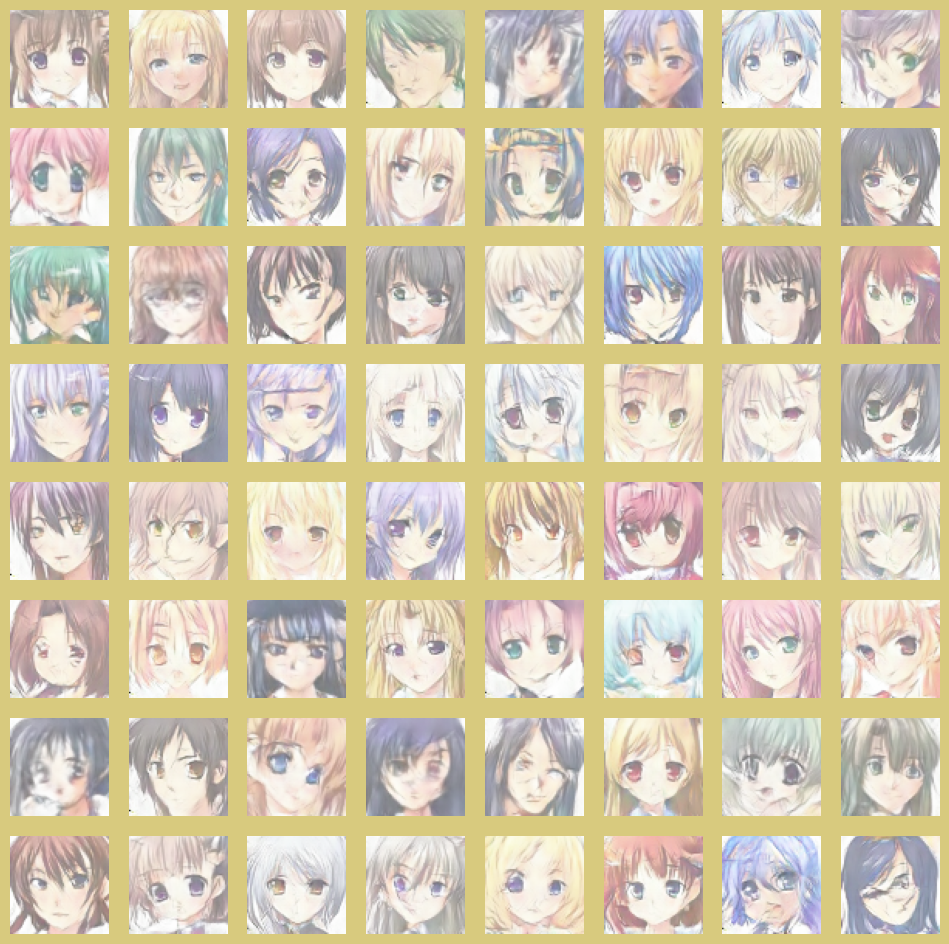

In [19]:
generate_faces()